# Singular Value Decomposition (SVD)

##### 2.c: evaluate the reconstruction performance on at least two IPSP datasets that were not part of the training

1. Load test data sets and U
3. Transform the test data into the reduced state with $$ X_{test,reduced} = U_{reduced}^T X_{test} $$
4. Reconstruct the reduced test data $ X_{test,reduced} $ with $$ X_{test,reconstr} = U_{reduced} X_{test,reduced}$$
5. Compare the reconstructed test set with the original test set using MSE and variance reconstruction

In [17]:
import sys
import os
from os.path import join
parent_dir = os.path.abspath(join(os.getcwd(), os.pardir))
app_dir = join(parent_dir, "app")
if app_dir not in sys.path:
      sys.path.append(app_dir)

import torch as pt
from torch import flatten
from os.path import join
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
import utils.config as config

random.seed(10)
plt.rcParams["figure.dpi"] = 180

DATA_PATH = Path(os.path.abspath('')).parent / "data"
OUTPUT_PATH = Path(os.path.abspath('')).parent / "output" / "SVD"

TIMESTEP = config.timestep_reconstruction
NEW_RES = (256, 128)

test_keys = ['ma0.84_alpha3.00', 'ma0.84_alpha5.00']

#### 1. Load test datasets and U

In [18]:
# Load test datsets
cp_084_data = pt.load(join(DATA_PATH, "cp_084_500snaps_interp.pt"))
X_test_1= cp_084_data[test_keys[0]].flatten(0, 1)
X_test_2 = cp_084_data[test_keys[1]].flatten(0, 1)

# Load left singular vectors
U = pt.load(join(OUTPUT_PATH, "U.pt"))

#### 2 - 4

In [19]:
# Create a list to loop over an increasing number of left singular vectors
ranks = range(0, 310, 10)

# Initialize lists to save the computed metrics
MSE_1 = []
MSE_2 = []
Var1 = []
Var2 = []

# compute the total variance test datasets
orig_Var1 = pt.var(X_test_1)
orig_Var2 = pt.var(X_test_2)

# Loop over the U ranks
for rank in ranks:
    # Compute MSE for test dataset 1
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_1
    reconstructed = U[:,:rank] @ reduced
    MSE_1.append(F.mse_loss(X_test_1, reconstructed).item())

    # Compute variance reconstruction for test dataset 1
    Var1.append((1 - ((orig_Var1 - pt.var(reconstructed)) / orig_Var1)) * 100)

    # Compute MSE for test dataset 2
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_2
    reconstructed = U[:,:rank] @ reduced
    MSE_2.append(F.mse_loss(X_test_2, reconstructed).item())

    # Compute variance reconstruction for test dataset 2
    Var2.append((1 - ((orig_Var2 - pt.var(reconstructed)) / orig_Var2)) * 100)
    


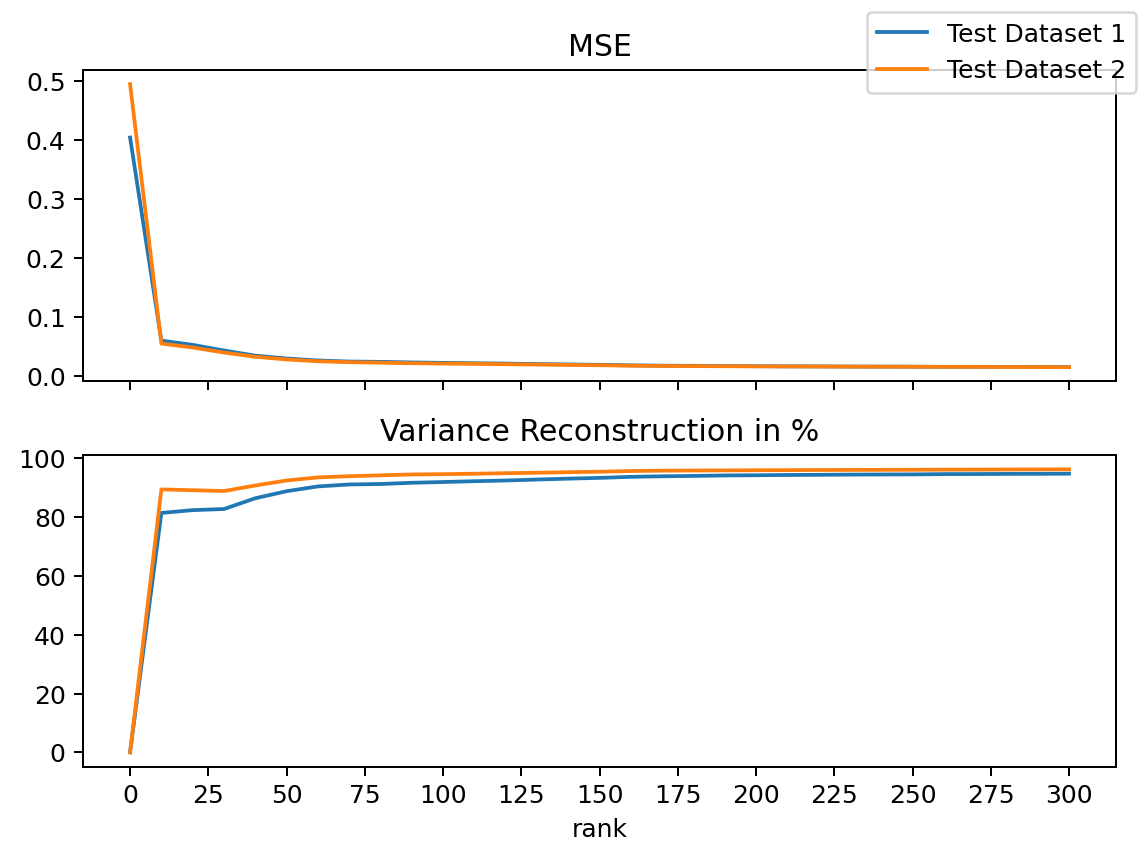

In [20]:
# Plot the results and save the figure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ranks, MSE_1, label="Test Dataset 1")
ax1.plot(ranks, MSE_2, label="Test Dataset 2")
ax1.set_title("MSE")
ax2.plot(ranks, Var1, label="Test Dataset 1")
ax2.plot(ranks, Var2, label="Test Dataset 2")
ax2.set_title("Variance Reconstruction in %")
ax2.set_xlabel("rank")
ax2.set_xticks(range(0, 325, 25))
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
fig.savefig(join(OUTPUT_PATH, "MSE_and_Variance_with_rank.png"), bbox_inches = "tight")

#### How is the error temporarily distributed?


ValueError: x and y must have same first dimension, but have shapes (1,) and torch.Size([500])

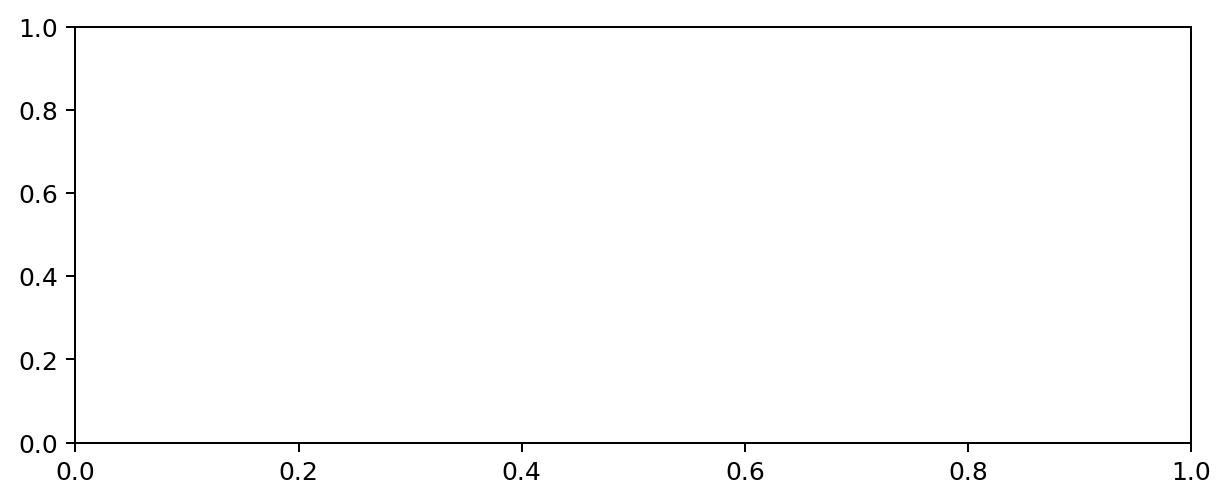

In [21]:
ranks = [2, 5, 10, 25, 50, 100, 250, 300, 1000]

fig, ax1 = plt.subplots(1, 1, figsize = (8, 3))
timesteps = config.time_steps_per_cond

# Loop over the U ranks
for rank in ranks:
    # Compute MSE for test dataset 1
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_1
    reconstructed = U[:,:rank] @ reduced
    mse = ((X_test_1 - reconstructed)**2).mean(0)
    ax1.plot(timesteps, mse, label="rank {}".format(rank))

# ax1.set_title("Test Dataset 1")
ax1.set_ylabel("MSE")
ax1.set_xlabel("timestep")

fig.legend()
fig.tight_layout()
fig.savefig(join(OUTPUT_PATH, "temporal_MSE_distribution.png"), bbox_inches = "tight")



#### How does the spatial error evolve for one specific timestep with inceasing rank?

In [ ]:
# Load coordinates
coords = pt.load(join(DATA_PATH, "coords_interp.pt"))
x, y = coords

In [ ]:
fig, axes = plt.subplots(2, 3, sharey=True)

# Loop over the U ranks
for i, rank in enumerate([5, 25, 250]):
    # reduce and reconstruct dataset
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_1
    reconstructed = U[:,:rank] @ reduced

    # compute the spatial MSE 
    mse1 = ((X_test_1 - reconstructed)**2).mean(1).unflatten(dim=0, sizes=NEW_RES)

    # reduce and reconstruct dataset
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_2
    reconstructed = U[:,:rank] @ reduced

    # compute the spatial MSE 
    mse2 = ((X_test_2 - reconstructed)**2).mean(1).unflatten(dim=0, sizes=NEW_RES)

    # compute the mean MSE and the corresponding standard deviation for the lowest rank to compare to higher ranks
    if i == 0:
        mean, std = mse1.mean(), mse1.std()
        vmin, vmax = 0, mean + 1*std
        levels = pt.linspace(vmin, vmax, 120)

        axes[0][i].set_ylabel("Test Dataset 1")
        axes[1][i].set_ylabel("Test Dataset 2")

    # create the contour plot
    cont = axes[0][i].contourf(x, y, mse1, vmin=vmin, vmax=vmax, levels=levels, extend="both")
    cont = axes[1][i].contourf(x, y, mse2, vmin=vmin, vmax=vmax, levels=levels, extend="both")

    # formatting
    axes[0][i].set_title("rank = {}".format(rank))

    for row in range(2):
        axes[row][i].set_aspect("equal")
        axes[row][i].set_xticklabels([])
        axes[row][i].set_yticklabels([])

# add seperate subplot for color axis
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.99, 0.042, 0.03, 0.885])
cbar = fig.colorbar(cont, cax=cax,label = "MSE")

fig.tight_layout()
fig.savefig(join(OUTPUT_PATH, "spatial_MSE_distribution.png"), bbox_inches = "tight")

#### How does the reconstructed timestep look like for different ranks?

In [ ]:
fig, axes = plt.subplots(2, 3, sharey=True)

# Loop over the U ranks
for i, rank in enumerate([5, 250, "experimental"]):
    
    # create the contour plot
    if rank == "experimental":
        cont = axes[0][i].contourf(x, y, X_test_1[:, TIMESTEP].unflatten(dim=0, sizes=NEW_RES), vmin=vmin, vmax=vmax, levels=levels, extend="both")
        cont = axes[1][i].contourf(x, y, X_test_2[:, TIMESTEP].unflatten(dim=0, sizes=NEW_RES), vmin=vmin, vmax=vmax, levels=levels, extend="both")
        axes[0][i].set_title("Ground Truth")
    else:
        # reduce and reconstruct dataset
        reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_1
        reconstructed = U[:,:rank] @ reduced
        reconstructed_timestep1 = reconstructed[:, TIMESTEP].unflatten(dim=0, sizes=NEW_RES)

        # reduce and reconstruct dataset
        reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_2
        reconstructed = U[:,:rank] @ reduced
        reconstructed_timestep2 = reconstructed[:, TIMESTEP].unflatten(dim=0, sizes=NEW_RES)

        # compute the mean MSE and the corresponding standard deviation for the lowest rank to compare to higher ranks
        if i == 0:
            mean, std = reconstructed_timestep1.mean(), reconstructed_timestep1.std()
            vmin, vmax = mean - 2*std, mean + 2*std
            levels = pt.linspace(vmin, vmax, 120)

            axes[0][i].set_ylabel("Test Dataset 1")
            axes[1][i].set_ylabel("Test Dataset 2")

        cont = axes[0][i].contourf(x, y, reconstructed_timestep1, vmin=vmin, vmax=vmax, levels=levels, extend="both")
        cont = axes[1][i].contourf(x, y, reconstructed_timestep2, vmin=vmin, vmax=vmax, levels=levels, extend="both")
        axes[0][i].set_title("rank = {}".format(rank))

    for row in range(2):
        axes[row][i].set_aspect("equal")
        axes[row][i].set_xticklabels([])
        axes[row][i].set_yticklabels([])

# add seperate subplot for color axis
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.99, 0.042, 0.03, 0.885])
cbar = fig.colorbar(cont, cax=cax,label = r"$c_p$")

fig.tight_layout()
fig.savefig(join(OUTPUT_PATH, "timestep_reconstruction.png"), bbox_inches = "tight")